# OD calculation
Notebook calculating the optical density and fitting the marginals (non-normalized) to a gaussian distribution.

This notebook includes some pointers on using `scikit-images` for image processing, which could be helpful.

It is important to note that the axes of images are flipped, ordered `[y][x]`.

In [1]:
#Imports

#path tools
from pathlib import Path
import os

#image processing
from skimage.io import imread, imshow
from skimage.measure import label, regionprops
from scipy.ndimage import median_filter

#other utils
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats.contingency import margins #compute marginals
from scipy.optimize import curve_fit

wd = Path(os.getcwd()) #current working directory
np.seterr(divide='ignore'); #doesn't end up mattering, suppress the annoying warning

In [4]:
example_dir = Path("../data/mar09/TOF_repeat") #test data directory

#each image has an accompanying background image with just noise
im0 = imread(example_dir / "image_277_0.tif")
im0_background = imread(example_dir / "image_277_2.tif")

#I am unclear on why the second image is necessary
im1 = imread(example_dir / "image_277_1.tif")
im1_background = imread(example_dir / "image_277_3.tif")

/tmp/ipykernel_248892/2697091872.py:10: RuntimeWarning: invalid value encountered in divide
  I_div_arr = np.divide(I_arr, I0_arr)


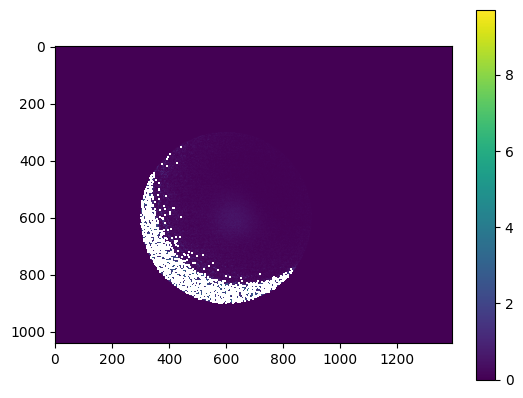

In [5]:
#get background intensity value with noise subtracted
I0_arr=np.subtract(np.array(im0),
                    np.array(im0_background)).astype(int)

#get foreground intensity with noise subtracted
I_arr=np.subtract(np.array(im1),
                    np.array(im1_background)).astype(int)


I_div_arr = np.divide(I_arr, I0_arr)
od_arr = np.log(I_div_arr)

def incircle(center, radius, pt):
    return (pt[0]-center[0])**2 + (pt[1]-center[1])**2 < radius**2

#first pass, just clip anything not within the aperture
for i,row in enumerate(od_arr):
    for j, pixel in enumerate(row):
        if pixel < 0 or not incircle((600,600),300,(i,j)):
            od_arr[i][j] = 0

img1 = plt.imshow(od_arr)
plt.colorbar(img1)

## Create image mask
A couple parameters can be used to mask out the unwanted data. First, `lower_mask` and `upper_mask` are just rough cutoff values. The `value_mask` parameter tries to get as much of the blob as possible while cutting off the noise. This can be set low, because the median mask will eliminate the outliers.

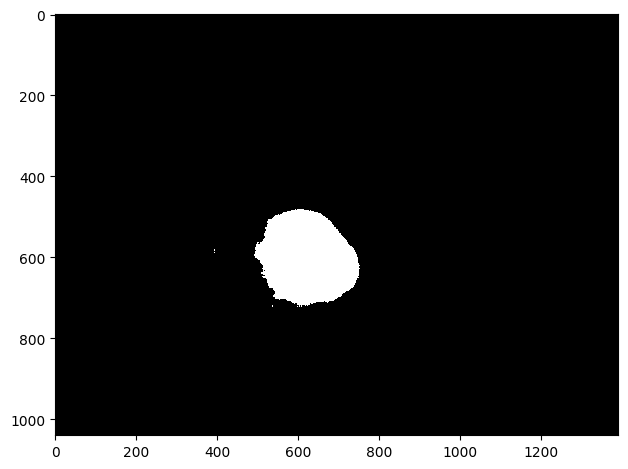

In [12]:
lower_mask = od_arr[:,:] > 0
upper_mask = od_arr[:,:] < 5
value_mask = od_arr[:,:] > .08
mask = lower_mask*upper_mask*value_mask

mask_filtered = median_filter(lower_mask*upper_mask*value_mask, 40)
imshow(mask_filtered)

## Get blob bounding box
THe `label` function is used to separate contiguous regions of the image and returns useful properties regarding their shape, location, and orientation.

In [13]:
blobs = label(mask_filtered)
props = regionprops(blobs) #generate a properties dictionary
bbox = props[0].bbox #get the bounding box
bbox 

(481, 491, 723, 752)

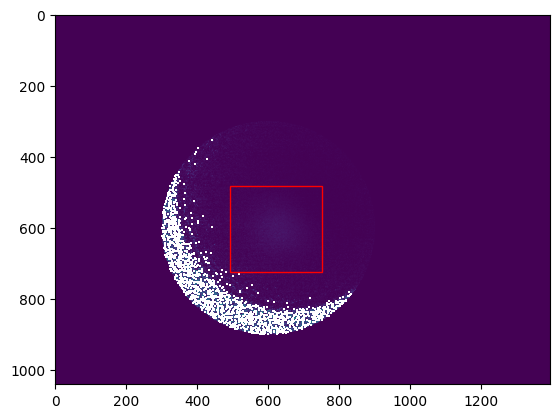

In [14]:
#draw bounding box
fig, ax = plt.subplots()
rect = plt.Rectangle((bbox[1],bbox[0]),bbox[3]-bbox[1], bbox[2]-bbox[0])
rect.set(fill=False, color = "red")
ax.add_artist(rect)
ax.imshow(od_arr)

In [15]:
#extract blob rectangle from image
blob_arr = od_arr[bbox[0]:bbox[2], bbox[1]:bbox[3]]
#apply a median filter
blob_arr = median_filter(blob_arr, 3)

In [16]:
#compute marginals and fit to a gaussian
def gaussian_fit(x, A, mu, sigma):
    return A*np.exp(-(x-mu)**2/(2*sigma**2))

x, y = margins(blob_arr)
x = x.T[0]
y = y[0]

popt_x, pcov_x = curve_fit(gaussian_fit, np.arange(len(x)), x, p0 =[350, 150, 60])
popt_y, pcov_y = curve_fit(gaussian_fit, np.arange(len(y)), y, [350,150,60])

<ErrorbarContainer object of 3 artists>

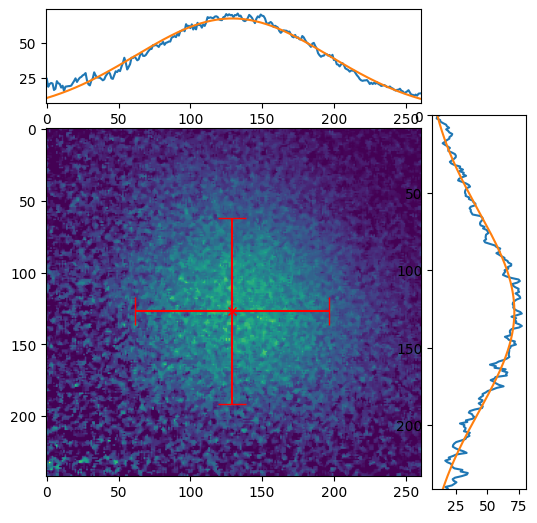

In [17]:
fig = plt.figure(figsize=(6,6))
gs = fig.add_gridspec(2, 2,  width_ratios=(4, 1), height_ratios=(1, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)
ax = fig.add_subplot(gs[1,0])
ax.imshow(blob_arr)

#axes are flipped!!
ax_y = fig.add_subplot(gs[0,0], sharex=ax)
ax_x = fig.add_subplot(gs[1,1], sharey=ax)

ax_y.plot(y)
ax_y.plot(np.arange(len(y)), gaussian_fit(np.arange(len(y)),*popt_y))

ax_x.plot(x, np.arange(len(x)))
ax_x.plot(gaussian_fit(np.arange(len(x)),*popt_x),np.arange(len(x)))

ax.errorbar(popt_y[1], popt_x[1], xerr = popt_y[2], yerr = popt_x[2], color = 'r', marker = "x", capsize = 10)

In [18]:
popt_x[1]

126.69821296602858

In [19]:
print("OD max:", np.max(blob_arr))

OD max: 0.8909729238898652
